In [1]:
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve(L, a, b, metric):

    x = cp.Variable(len(a))

    if metric == "sw":
        objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    elif (metric == "pf") or (metric == 1):
        objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a, x) + b - L)))
    elif metric == "mm":
        objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    else:
        y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
        objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))
               
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(objective, constraints)
#     problem.solve(solver="OSQP")
    problem.solve(solver="ECOS", abstol=1e-6)

    user_surplus = -0.5*a*x.value**2 + (b - L)*x.value
    surplus = np.sum(user_surplus)
    
    return problem.value, x.value, user_surplus, surplus


def solve_wrapper(params):
    
    L = params["L"]
    seed = params["seed"]
    n_users = params["n_users"]

    np.random.seed(seed)
    a = 1*np.random.rand(n_users) + 1
    b = (a + 1)*L + 10*np.random.rand(n_users) + 1
        
    try:
        warnings.simplefilter("error")
        assert check_feasibility(L, a, b), "infeasible"
        sw_val, sw_sol, sw_user_surplus, sw_surplus = solve(L, a, b, "sw")
        pf_val, pf_sol, pf_user_surplus, pf_surplus = solve(L, a, b, "pf")
        mm_val, mm_sol, mm_user_surplus, mm_surplus = solve(L, a, b, "mm")
        alpha0_val, alpha0_sol, alpha0_user_surplus, alpha0_surplus = solve(L, a, b, 0.5)
        alpha1_val, alpha1_sol, alpha1_user_surplus, alpha1_surplus = solve(L, a, b, 1.5)
        #alpha2_val, alpha2_sol, alpha2_user_surplus, alpha2_surplus = solve(L, a, b, 3.0)
        message = "success"

    except (Warning, cp.SolverError, TypeError) as e:
        sw_val, sw_sol, sw_user_surplus, sw_surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan
        pf_val, pf_sol, pf_user_surplus, pf_surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan
        mm_val, mm_sol, mm_user_surplus, mm_surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan
        alpha0_val, alpha0_sol, alpha0_user_surplus, alpha0_surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan
        alpha1_val, alpha1_sol, alpha1_user_surplus, alpha1_surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan
        #alpha2_val, alpha2_sol, alpha2_user_surplus, alpha2_surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan        
        message = str(e)
        
    return dict(
        n_users=n_users, seed=seed, message=message, 
        sw_val=sw_val, sw_sol=sw_sol, sw_surplus=sw_surplus, sw_min_surplus=np.min(sw_user_surplus),
        pf_val=pf_val, pf_sol=pf_sol, pf_surplus=pf_surplus, pf_min_surplus=np.min(pf_user_surplus),
        mm_val=mm_val, mm_sol=mm_sol, mm_surplus=mm_surplus, mm_min_surplus=np.min(mm_user_surplus),
        alpha0_val=alpha0_val, alpha0_sol=alpha0_sol, alpha0_surplus=alpha0_surplus, alpha0_min_surplus=np.min(alpha0_user_surplus),
        alpha1_val=alpha1_val, alpha1_sol=alpha1_sol, alpha1_surplus=alpha1_surplus, alpha1_min_surplus=np.min(alpha1_user_surplus),
        #alpha2_val=alpha2_val, alpha2_sol=alpha2_sol, alpha2_surplus=alpha2_surplus, alpha2_min_surplus=np.min(alpha2_user_surplus),
    )

In [10]:
%%time
params_list = [
    dict(L=L, n_users=n_users, seed=seed)
    for L in [1] 
    for n_users in [10, 100, 1000]
    for seed in range(10)
]

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
pool.close()

CPU times: user 56.7 ms, sys: 377 ms, total: 433 ms
Wall time: 741 ms


In [11]:
# calculate price of fairness/efficiency (pof/poe)
df = pd.DataFrame(results)#.dropna()
df

,n_users,seed,message,sw_val,sw_sol,sw_surplus,sw_min_surplus,pf_val,pf_sol,pf_surplus,...,mm_surplus,mm_min_surplus,alpha0_val,alpha0_sol,alpha0_surplus,alpha0_min_surplus,alpha1_val,alpha1_sol,alpha1_surplus,alpha1_min_surplus
0,10,0,success,11.198001,"[5.745262158531223e-09, 3.4168714378648787e-10...",11.198001,-5.453513e-10,-3.579589,"[0.10059007579936323, 0.10024963435517467, 0.1...",8.034605,...,5.759554,0.575955,17.896284,"[0.1296129640431706, 0.09882386240621806, 0.10...",9.478124,0.085714,-24.637336,"[0.08653147221876817, 0.09450206799275271, 0.0...",7.339931,0.344277
1,10,1,success,10.432341,"[1.8979242105186212e-10, 1.0272635733648544e-0...",10.432341,-3.097789e-10,-5.374492,"[0.1001417611975874, 0.10031947043410568, 0.09...",6.461654,...,5.178812,0.517881,16.058727,"[0.10127398193365562, 0.1456797005500409, 0.06...",7.532842,0.089546,-26.665303,"[0.09536173748934398, 0.08436126931946476, 0.1...",6.049487,0.310087
2,10,2,success,10.442697,"[5.422662172650684e-10, 1.3760078008012005e-10...",10.442697,-2.382919e-10,-3.941251,"[0.10028484128150247, 0.10041705139393269, 0.0...",7.347975,...,6.053563,0.605356,17.128029,"[0.11661720454180514, 0.0995017257307733, 0.05...",8.311794,0.125889,-24.767502,"[0.09160011089021779, 0.09687028391777851, 0.1...",6.946063,0.383340
3,10,3,success,8.908035,"[6.433639146852134e-11, 7.579161634956e-10, 0....",8.908035,-1.748582e-10,-5.511457,"[0.09859139378558596, 0.10018005214175782, 0.1...",6.346160,...,5.052466,0.505247,15.912295,"[0.04444984760634159, 0.11309621920434784, 0.1...",7.215410,0.087371,-26.870892,"[0.12463318839972246, 0.09198010852651718, 0.0...",5.959701,0.304067
4,10,4,success,11.910946,"[9.221564548153166e-10, -4.90680008100683e-11,...",11.910946,-2.219877e-10,-4.362523,"[0.10048498219917296, 0.09966656200952295, 0.1...",7.507286,...,5.441229,0.544123,17.295856,"[0.14137614260867096, 0.05992948076442976, 0.1...",9.274026,0.095931,-25.579660,"[0.08360500748054298, 0.11115142544709034, 0.0...",6.812262,0.343582
5,10,5,success,10.574495,"[-1.420451592716284e-10, 0.13565919383851766, ...",10.574495,-4.303124e-10,-4.356264,"[0.09919341173218893, 0.10032569752302781, 0.1...",6.936007,...,5.962210,0.596221,16.643021,"[0.04354282152778349, 0.1453910689115907, 0.09...",7.766263,0.130750,-25.187339,"[0.12769843330402586, 0.08561060843022528, 0.0...",6.625891,0.376887
6,10,6,success,11.706313,"[3.0142660970560105e-10, 2.5930405568832335e-0...",11.706313,6.043309e-10,-0.998134,"[0.09951316168739123, 0.10013709747761793, 0.0...",9.238944,...,8.859448,0.885945,19.220565,"[0.07761501890459131, 0.10433084982597746, 0.0...",9.598768,0.457838,-21.097249,"[0.10740578859499915, 0.09785544251103638, 0.1...",9.113820,0.720227
7,10,7,success,11.257770,"[1.8100561358705759e-09, 6.795854282453063e-08...",11.257770,-1.796464e-09,-4.441740,"[0.10073062050142477, 0.10050885848383485, 0.1...",7.184119,...,5.608744,0.560874,16.927687,"[0.12352449459034517, 0.14850816285660193, 0.0...",8.516688,0.103245,-25.508456,"[0.0893227411370688, 0.08355950381336466, 0.10...",6.671875,0.346007
8,10,8,success,11.439728,"[2.572983938352394e-10, 2.6625841846797327e-10...",11.439728,-4.788171e-11,-2.808020,"[0.09991773157585165, 0.0998566386917192, 0.10...",7.894356,...,7.204688,0.720469,17.762408,"[0.10516098944130613, 0.10467396810011759, 0.1...",8.535724,0.271218,-23.192190,"[0.09628387811650871, 0.09635803436291974, 0.0...",7.667329,0.535417
9,10,9,success,11.416289,"[-6.16395631949481e-11, 0.1442421682000232, 0....",11.416289,-1.260109e-09,-2.813870,"[0.09952384372340413, 0.10024494297909083, 0.1...",8.332091,...,6.445631,0.644563,18.239003,"[0.04411522048049507, 0.13420144611754375, 0.1...",9.372469,0.075564,-23.542694,"[0.1254110998095819, 0.0866511186786135, 0.084...",7.807695,0.345306


In [29]:
# calculate price of fairness/efficiency (pof/poe)
df = pd.DataFrame(results).dropna()

df["Proportional (α=1.0)"] = (df.sw_surplus - df.pf_surplus) / df.sw_surplus
df["Max-Min (α=∞)"] = (df.sw_surplus - df.mm_surplus) / df.sw_surplus
df["α=0.5"] = (df.sw_surplus - df.alpha0_surplus) / df.sw_surplus
df["α=1.5"] = (df.sw_surplus - df.alpha1_surplus) / df.sw_surplus

#df["sw_poe"] = (df.mm_min_surplus - df.sw_min_surplus) / df.mm_min_surplus
#df["pf_poe"] = (df.mm_min_surplus - df.pf_min_surplus) / df.mm_min_surplus

df

,n_users,seed,message,sw_val,sw_sol,sw_surplus,sw_min_surplus,pf_val,pf_sol,pf_surplus,...,alpha0_surplus,alpha0_min_surplus,alpha1_val,alpha1_sol,alpha1_surplus,alpha1_min_surplus,Proportional (α=1.0),Max-Min (α=∞),α=0.5,α=1.5
0,10,0,success,11.198001,"[5.745262158531223e-09, 3.4168714378648787e-10...",11.198001,-5.453513e-10,-3.579589,"[0.10059007579936323, 0.10024963435517467, 0.1...",8.034605,...,9.478124,0.085714,-24.637336,"[0.08653147221876817, 0.09450206799275271, 0.0...",7.339931,0.344277,0.282496,0.485662,0.153588,0.344532
1,10,1,success,10.432341,"[1.8979242105186212e-10, 1.0272635733648544e-0...",10.432341,-3.097789e-10,-5.374492,"[0.1001417611975874, 0.10031947043410568, 0.09...",6.461654,...,7.532842,0.089546,-26.665303,"[0.09536173748934398, 0.08436126931946476, 0.1...",6.049487,0.310087,0.380613,0.503581,0.277934,0.420122
2,10,2,success,10.442697,"[5.422662172650684e-10, 1.3760078008012005e-10...",10.442697,-2.382919e-10,-3.941251,"[0.10028484128150247, 0.10041705139393269, 0.0...",7.347975,...,8.311794,0.125889,-24.767502,"[0.09160011089021779, 0.09687028391777851, 0.1...",6.946063,0.383340,0.296353,0.420307,0.204057,0.334840
3,10,3,success,8.908035,"[6.433639146852134e-11, 7.579161634956e-10, 0....",8.908035,-1.748582e-10,-5.511457,"[0.09859139378558596, 0.10018005214175782, 0.1...",6.346160,...,7.215410,0.087371,-26.870892,"[0.12463318839972246, 0.09198010852651718, 0.0...",5.959701,0.304067,0.287591,0.432819,0.190011,0.330975
4,10,4,success,11.910946,"[9.221564548153166e-10, -4.90680008100683e-11,...",11.910946,-2.219877e-10,-4.362523,"[0.10048498219917296, 0.09966656200952295, 0.1...",7.507286,...,9.274026,0.095931,-25.579660,"[0.08360500748054298, 0.11115142544709034, 0.0...",6.812262,0.343582,0.369715,0.543174,0.221386,0.428067
5,10,5,success,10.574495,"[-1.420451592716284e-10, 0.13565919383851766, ...",10.574495,-4.303124e-10,-4.356264,"[0.09919341173218893, 0.10032569752302781, 0.1...",6.936007,...,7.766263,0.130750,-25.187339,"[0.12769843330402586, 0.08561060843022528, 0.0...",6.625891,0.376887,0.344082,0.436171,0.265567,0.373408
6,10,6,success,11.706313,"[3.0142660970560105e-10, 2.5930405568832335e-0...",11.706313,6.043309e-10,-0.998134,"[0.09951316168739123, 0.10013709747761793, 0.0...",9.238944,...,9.598768,0.457838,-21.097249,"[0.10740578859499915, 0.09785544251103638, 0.1...",9.113820,0.720227,0.210773,0.243191,0.180035,0.221461
7,10,7,success,11.257770,"[1.8100561358705759e-09, 6.795854282453063e-08...",11.257770,-1.796464e-09,-4.441740,"[0.10073062050142477, 0.10050885848383485, 0.1...",7.184119,...,8.516688,0.103245,-25.508456,"[0.0893227411370688, 0.08355950381336466, 0.10...",6.671875,0.346007,0.361852,0.501789,0.243484,0.407354
8,10,8,success,11.439728,"[2.572983938352394e-10, 2.6625841846797327e-10...",11.439728,-4.788171e-11,-2.808020,"[0.09991773157585165, 0.0998566386917192, 0.10...",7.894356,...,8.535724,0.271218,-23.192190,"[0.09628387811650871, 0.09635803436291974, 0.0...",7.667329,0.535417,0.309917,0.370205,0.253853,0.329763
9,10,9,success,11.416289,"[-6.16395631949481e-11, 0.1442421682000232, 0....",11.416289,-1.260109e-09,-2.813870,"[0.09952384372340413, 0.10024494297909083, 0.1...",8.332091,...,9.372469,0.075564,-23.542694,"[0.1254110998095819, 0.0866511186786135, 0.084...",7.807695,0.345306,0.270158,0.435400,0.179027,0.316092


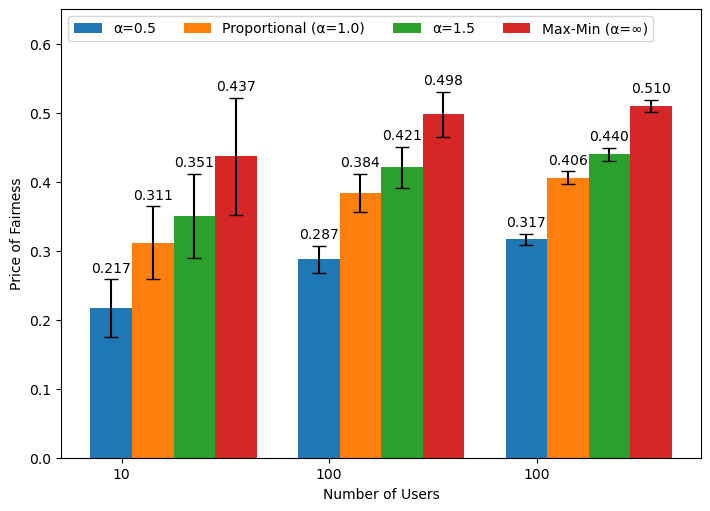

In [47]:
# Hypothetical error values for each attribute
n_users = (10, 100, 100)

df_errors = df.groupby("n_users")[["α=0.5", "Proportional (α=1.0)",  "α=1.5", "Max-Min (α=∞)"]].std().to_dict()
df_errors = {k:list(v.values())  for k,v in df_errors.items()}

df_means = df.groupby("n_users")[["α=0.5", "Proportional (α=1.0)", "α=1.5", "Max-Min (α=∞)"]].mean().to_dict()
df_means = {k:list(v.values())  for k,v in df_means.items()}

x = np.arange(len(n_users))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(7, 5))

for attribute, measurement in df_means.items():
    offset = width * multiplier
    error = df_errors[attribute]  # Get the corresponding error values
    rects = ax.bar(x + offset, measurement, width, label=attribute, yerr=error, capsize=5)  # Add error bars
    ax.bar_label(rects, padding=3, fmt="%.3f")
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Price of Fairness')
ax.set_xticks(x + width / 4, n_users)  # Adjust the position of the x-ticks to align them with the groups of bars
ax.legend(loc='upper left', ncol=4)
ax.set_ylim(0, 0.65)
ax.set_xlabel("Number of Users")
plt.show()
